# Regression Modelling by Date

In [11]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import random
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [6]:
stations = pd.read_csv("../CSVFiles/stations.csv").drop(columns=["Unnamed: 0"])

max_cluster = [2, 3, 5, 7, 8, 9, 10, 27, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 42]
min_cluster = [1, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 34]

stations.head()

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


In [7]:
trips = pd.read_csv("../CSVFiles/tripsStationHour.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
working_day = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    working_day.append(0 if date.tm_wday >= 5 else 1)
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips["Day"] = day
trips["Year"] = year
trips["WorkingDay"] = working_day
trips = trips.drop(columns=["DateEnd"])

dataset = trips.loc[trips["StationEnd"].isin(min_cluster)]
dataset.head()

,Hour,StationEnd,Count,Day,Year,WorkingDay
0,0,26,1,1,2011,0
1,0,17,1,1,2011,0
13,1,21,1,1,2011,0
16,1,19,1,1,2011,0
21,1,13,1,1,2011,0


[20.404371584699454, 12.797814207650271, 8.65846994535519, 4.363387978142076, 2.3114754098360653, 7.778688524590163, 29.161202185792344, 81.53005464480873, 137.97540983606555, 84.15573770491804, 67.0327868852459, 80.42349726775956, 97.57103825136612, 98.0655737704918, 92.85519125683061, 96.5846994535519, 120.68306010928961, 178.5846994535519, 162.99180327868854, 120.43715846994537, 87.17486338797814, 66.18579234972678, 50.33333333333333, 33.87978142076503]


Text(0.5, 1.0, 'Day by hours')

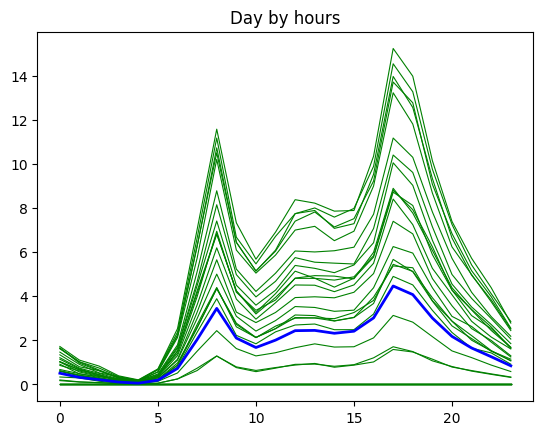

In [8]:
cnt = {x:[0 for y in range(0,24)] for x in stations["Station ID"]}

for trip in dataset.values:
    cnt[trip[1]][trip[0]] += trip[2]
    
from operator import add

avg = [0 for x in range(0,24)]
index = 0
# legend = []
for day, cont in cnt.items():
    plt.plot(list(range(len(cont))), [x/366 for x in cont], linewidth=0.8, color="green")
    avg = list( map(add, avg, [x/366 for x in cont]) )
#     legend.append(f"{day}")
# plt.legend(legend)

plt.plot(list(range(len(avg))), [x/len(cnt.keys()) for x in avg], linewidth=2, color="blue")
print(avg)

plt.title("Day by hours")

## Regression

In [12]:
mse_array = [1.5560460052966003, 1.1546453573093387, 1.1152016004689544, 1.1061674361909062, 1.094941809874997, 1.0971526368664617]

first_hour = dataset.values[0][0]
first_day = dataset.values[0][3]
first_year = dataset.values[0][4]

mse_array2 = [1.7, 1.0, 1.0, 1.0, 1.0, 1.0]

### Method 1
Input: c(t)

Output: c(t+1)

In [7]:
X = dataset.drop(columns=["Count", "Year", "Day"])
y = dataset["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_median_absolute_error", groups=dataset["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.5560460052966003
Mean Absolute Error: 1.7


### Method 2
Input: c(t), c(t-1)

Output: c(t+1)

In [8]:
count_met2 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_met2 += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method2 = dataset[count_met2:].copy()
dataset_method2["Count1"] = cnt

X = dataset_method2.drop(columns=["Count", "Year", "Day"])
y = dataset_method2["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_median_absolute_error", groups=dataset_method2["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.1546453573093387
Mean Absolute Error: 1.0


### Method 3
Input: c(t), c(t-1), c(t-1semana)

Output: c(t+1)

In [9]:
count_met3 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_met3 += 1
        continue

    day -= 7

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method3 = dataset_method2[count_met3-count_met2:].copy()
dataset_method3["Count1week"] = cnt

X = dataset_method3.drop(columns=["Count", "Year", "Day"])
y = dataset_method3["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_median_absolute_error", groups=dataset_method3["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.1152016004689544
Mean Absolute Error: 1.0


### Method 4
Input: c(t), c(t-1), c(t-1semana), c(t-2semana)

Output: c(t+1)

In [18]:
count_met4 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_met4 += 1
        continue

    day -= 14

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method4 = dataset_method3[count_met4-count_met3:].copy()
dataset_method4["Count2week"] = cnt

X = dataset_method4.drop(columns=["Count", "Year", "Day"])
y = dataset_method4["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_median_absolute_error", groups=dataset_method4["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.1061674361909062
Mean Absolute Error: 1.0


### Method 5
Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana)

Output: c(t+1)

In [ ]:
count_met5 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_met5 += 1
        continue

    day -= 21

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method5 = dataset_method4[count_met5-count_met4:].copy()
dataset_method5["Count3week"] = cnt

X = dataset_method5.drop(columns=["Count", "Year", "Day"])
y = dataset_method5["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_median_absolute_error", groups=dataset_method5["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.094941809874997
Mean Absolute Error: 1.0


### Method 6
Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana), c(t-4semana)

Output: c(t+1)

In [12]:
count_met6 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 28:
        count_met6 += 1
        continue

    day -= 28

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method6 = dataset_method5[count_met6-count_met5:].copy()
dataset_method6["Count4week"] = cnt

X = dataset_method6.drop(columns=["Count", "Year", "Day"])
y = dataset_method6["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_median_absolute_error", groups=dataset_method6["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.0971526368664617
Mean Absolute Error: 1.0


## Graphs

Text(0.5, 0, 'Methods')

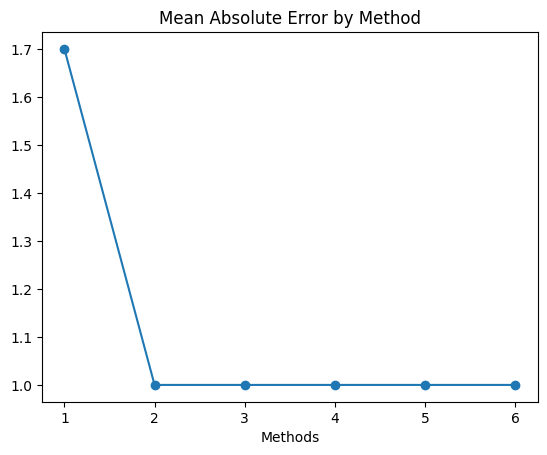

In [13]:
# plt.plot(list(range(1,len(mse_array)+1)), mse_array, marker="o")
plt.plot(list(range(1,len(mse_array)+1)), mse_array2, marker="o")
plt.title("Mean Absolute Error by Method")
plt.xlabel("Methods")

In [14]:
dataset_method2.to_csv("../DateDatasets/dataset.csv")